In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("SrF_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



## Define SrF Hamiltonian and molecular states

In [3]:
μ_B = 9.2740100783e-24
package = get_SrF_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = package; # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

In [4]:
# display.(package.states)
# energy.(package.states) .- energy(package.states[1])

In [5]:
package.states[10]

State{HundsCaseB_Rot}(1.5268024975647594e10, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 0, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:0.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 0, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, -1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 0, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 1/2, 1, 1, (N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, 0, 1, 3/2, 1, -1, (N =

## Define experimental parameters

In [103]:

## Initial condition of the molecule cloud
temp = @with_unit 1 "mK"
diameter = @with_unit 1 "mm"
displacement = [0.0, 0.0, 0.0]*4e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = 80 ; ramp_time = 8e-3

## Laser detunings

Δ = 6e6
δ = 0.6e6

Δ1 = Δ 
Δ2 = Δ + 3e6
Δ3 = Δ - δ
Δ4 = Δ + δ
Δ5 = 0

s1 = 1.8
s2 = 5
s3 = 0.8
s4 = 0.8
s5 = 0




blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 100,
                                pol1_x=σ⁺, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 1,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =0.017)
;

## Find the diffusion constant

In [104]:

# res, diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-3, n_particles=20, 
#                                         ramp_time=1e-6, temp = 1e-4, diameter=200e-6)
# blue_MOT_params.diffusion_constant = diffusion_constant
# @printf("Diffusion const = %.3f \n", diffusion_constant)

## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [105]:
blue_MOT_params.n_values = 40
sequence = [blue_MOT_params]
durations = [10e-3]
generate_sequence!(sequence, durations);
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:29


149.984328 seconds (109.41 k allocations: 26.756 MiB)


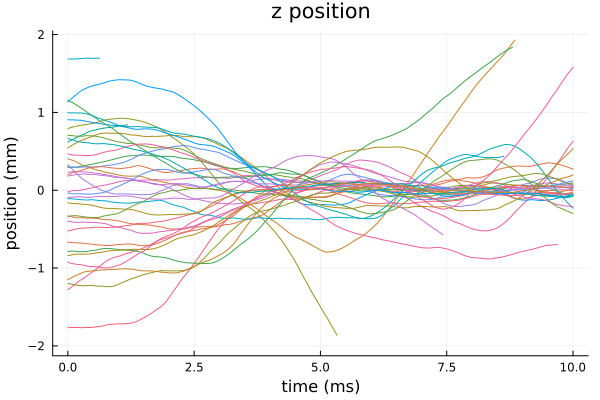

In [106]:
plot_all_trajectories(results, "z")
plot!()

In [111]:
results1 = bootstrap_iteration(results;n_values=40);

In [112]:
bootstrap_size_fit(results1, 10)

(0.08401004927765296, 0.03286564471671992)

In [113]:
bootstrap_temperature_fit(results1, 9)

(101.80389092868295, 59.7423444762489)

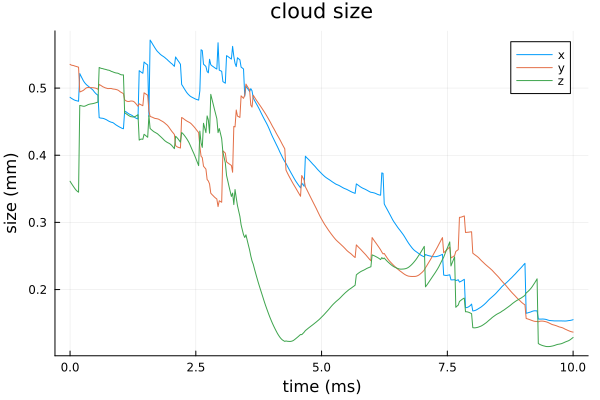

In [110]:
plot_size(results,"all")
plot!()

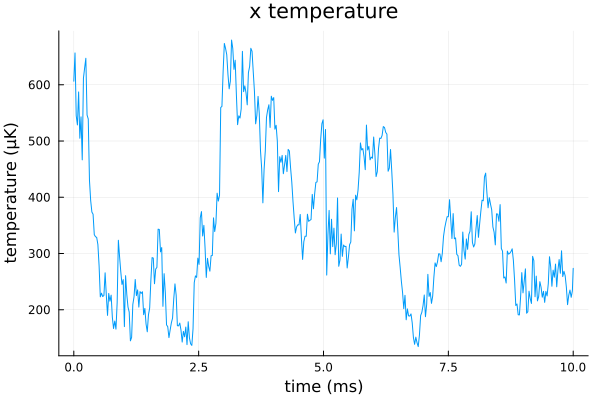

In [83]:
plot_temperature(results,"x")
plot!()

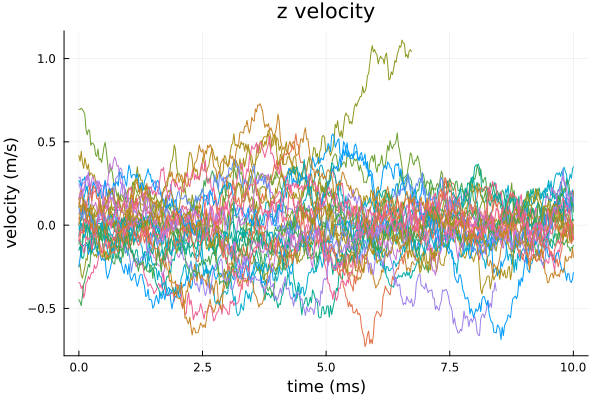

In [84]:
plot_all_velocities(results,"z")
plot!()

In [223]:
# using MAT

# saving_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\toy_model_sim"

# file_path = joinpath(saving_dir, "trajectories_2_and_3_freq.mat");

# file = matopen(file_path, "w")

# write(file, "times_2", results2.times)
# write(file, "trajectories_2", results2.z_trajectories)
# write(file, "times_3", results3.times)
# write(file, "trajectories_3", results3.z_trajectories)

# close(file);

In [ ]:
bootstrap_size_fit(results,9;iter=100)

(0.07207841433418082, 0.0029348902046640217)

In [60]:
results3 = results;

In [59]:
bootstrap_temperature_fit(results,5;iter=100)

(246.9092084496682, 20.351031924640623)

In [26]:
bootstrap_size_fit(results,5;iter=100)

(0.03945307493387002, 0.0008944483967156512)

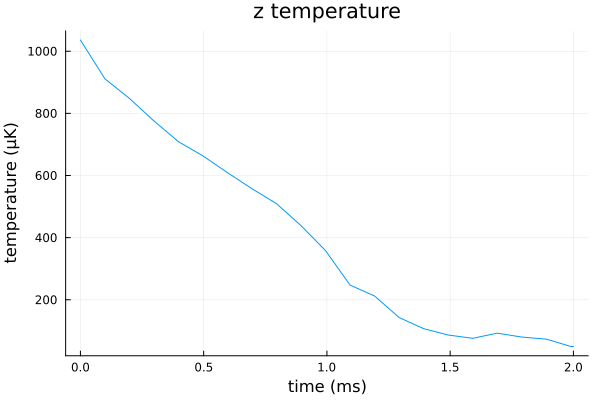

In [77]:
plot_temperature(results, "z")
plot!()

In [7]:
results1 = bootstrap_iteration(results,n_values=100);
plot_all_trajectories(results1, "z")
p1 = plot!(ylim = [-2,2],title="",ylabel="z (mm)")

Progress:  75%|███████████████████████████████          |  ETA: 0:50:34

LoadError: UndefVarError: `results` not defined

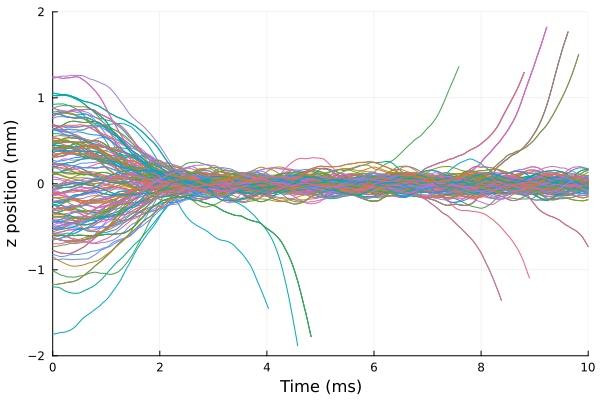

In [25]:
results1 = bootstrap_iteration(results3,n_values=200);
plot_all_trajectories(results1, "z")
p1 = plot!(ylim = [-2,2],title="",xlim=[0,10],xlabel="Time (ms)", ylabel="z position (mm)")

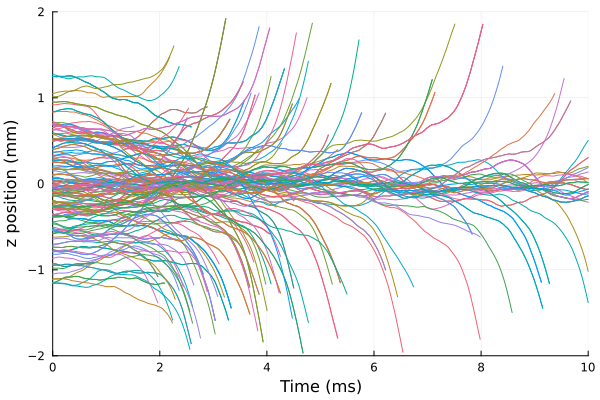

In [62]:
results1 = bootstrap_iteration(results2,n_values=200);
plot_all_trajectories(results1, "z")
p2 = plot!(ylim = [-2,2],title="",ylabel="z position (mm)",xlim=[0,10], xlabel="Time (ms)")

In [ ]:
p1

In [63]:
plot(p1, p2, size=(400,180),xtickfontsize=9,ytickfontsize=9,xguidefontsize=9,yguidefontsize=9,legendfontsize=9,bottom_margin=5Plots.mm,legend=false)
plot!(grid=:off, framestyle=:box,dpi=300, linewidth=1,fontfamily="times",xguidefontcolor=:black, yguidefontcolor=:black)
plot!(x_foreground_color_axis=:black, y_foreground_color_axis=:black, x_foreground_color_border=:black, y_foreground_color_border = :black)
savefig("trajectories_2_3.png")

"G:\\My Drive\\github\\OpticalBlochEquations\\examples\\CaOH_blue_MOT_example\\trajectories_2_3.png"

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


In [34]:
results3 = results;

### Or load an existing simulation result
The example here is a 1000 particle blue MOT simulation for 7.1 ms

In [5]:
results = load_results("",1);

## Plot simulation results

### Plot the molecules' trajectories

Note that molecules that are too far away from the centre are discarded, which is why some trajectories end prematurely.

In [9]:
# plot_all_velocities(results, "z")
# plot!(ylim=[-2,2])

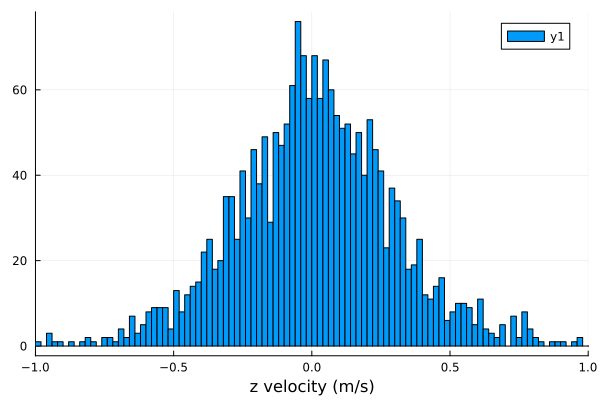

In [87]:
t = 1.1
id_survived = survived_t(results, t)
dt = results.times[1][2]-results.times[1][1]
t_j = Int(floor(t ÷ dt))
    
x_grid = collect(LinRange(-1, 1, 20))
xs = [results.x_velocities[j][t_j] for j in id_survived]
density_x = distribution_to_func(x_grid, xs);
dx = 0.02
bins = Int((maximum(xs)-minimum(xs))÷dx)
histogram(xs, bins=bins,xlim=[-1,1], xlabel="z velocity (m/s)")

### Plot the cloud size over time 
The size here is obtained from the standard deviation of the position distribution.
There is also an option to find the final cloud size by fitting to a Gaussian.

Final size = 0.094 mm

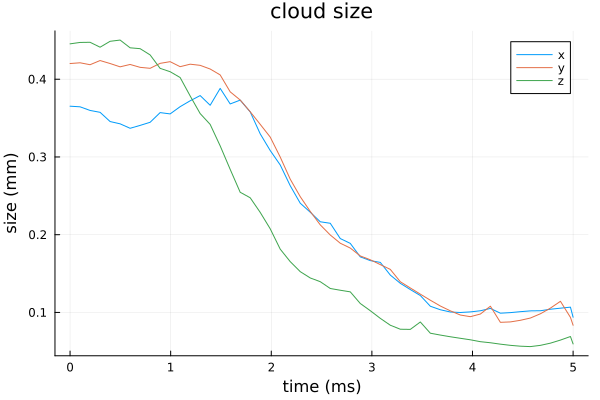

In [14]:
~, σ = plot_size(results,"all")
@printf("Final size = %.3f mm", σ[end])
plot!()

In [15]:
bootstrap_size_fit(results,5,iter=100)

(0.06337209352816585, 0.004092925019390378)

In [17]:
bootstrap_temperature_fit(results,5,iter=100)

(180.44273870496866, 18.03513434600427)

### Plot temperature over time 
Temperatures here are obtained from the standard deviation of the velocity distribution. One could also fit the velocity distribution to a Gaussian.

Temperature = 220.1 uK

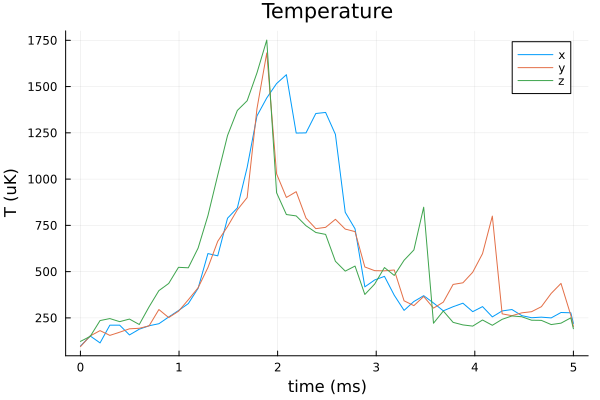

In [16]:
~, T = plot_temperature(results, "all")
@printf("Temperature = %.1f uK", T[end])
plot!()

### Plot the scattering rate of the molecules 
Scattering rate = excited state population * Γ

Average scattering rate = 1.19 MHz

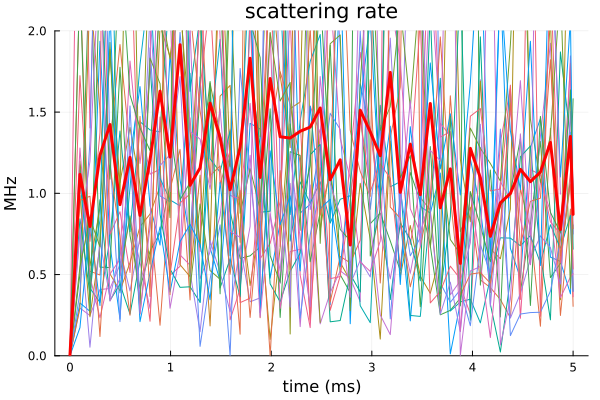

In [12]:
sr = plot_scattering_rate(results)
@printf("Average scattering rate = %.2f MHz", sr)
plot!(ylim=[0,2])

### Simulate camera images
We can also generate "camera images" by taking 2D snapshots (integrated over y direction) of the molecules.

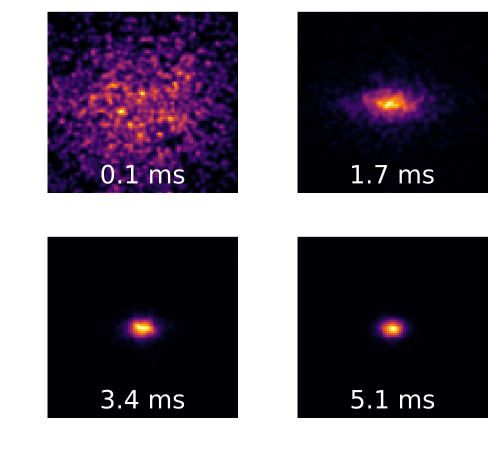

In [32]:
ROI = 0.8  # mm

img_duration = 2.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.1,1.7,3.4,5.1]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',legend=:none, xaxis=false, yaxis=false)
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(500,450))
    
plot!()

In [28]:
import OpticalBlochEquations.simulate_particles_constant_diffusion

function make_problem_with_param_constant_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k 

    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x, pol5_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x, param.pol5_x

    s1, s2, s3, s4, s5 = param.s1, param.s2, param.s3, param.s4, param.s5
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4, Δ5 = param.Δ1, param.Δ2, param.Δ3, param.Δ4, param.Δ5
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick
    
    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1],m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2],m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3],m)
  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
   photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,
        
        s_total = s1 + s2 + s3 + s4,
        diffusion_constant = param.diffusion_constant
        )

    t_span = (t_start, t_end) ./ (1/Γ);
    
    ω1 = 2π * (states[end].E - states[1].E) + 2π * Δ1
    ω2 = 2π * (states[end].E - states[6].E) + 2π * Δ2
    ω3 = 2π * (states[end].E - states[10].E) + 2π * Δ3
    ω4 = 2π * (states[end].E - states[10].E) + 2π * Δ4
    ω5 = 2π * (states[end].E - states[10].E) + 2π * Δ5

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance) + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    rand5 = rand()
    pol5_x = pol5_x.*sqrt(1 - imbalance) + flip(pol5_x).*sqrt(imbalance)*exp(im*2π*rand5)    

    sx_rand = 1/2-rand()
    sy_rand = 1/2-rand()
    sz_rand = 1/2-rand()
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    s5x = s5 * (1+sx_imbalance*sx_rand)
    s5y = s5 * (1+sy_imbalance*sy_rand)
    s5z = s5 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ25 = ϕs[1]*rotate_pol(pol5_x, k̂); ϵ_func25 = ϵ_(ϵ25, 1); laser25 = Field(k̂, ϵ_func25, ω5, s_gaussian_ramp(s5x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ26 = ϕs[2]*rotate_pol(pol5_x, k̂); ϵ_func26 = ϵ_(ϵ26, 2); laser26 = Field(k̂, ϵ_func26, ω5, s_gaussian_ramp(s5x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ27 = ϕs[3]*rotate_pol(pol5_x, k̂); ϵ_func27 = ϵ_(ϵ27, 3); laser27 = Field(k̂, ϵ_func27, ω5, s_gaussian_ramp(s5y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ28 = ϕs[4]*rotate_pol(pol5_x, k̂); ϵ_func28 = ϵ_(ϵ28, 4); laser28 = Field(k̂, ϵ_func28, ω5, s_gaussian_ramp(s5y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ29 = ϕs[5]*rotate_pol(flip(pol5_x), k̂); ϵ_func29 = ϵ_(ϵ29, 5); laser29 = Field(k̂, ϵ_func29, ω5, s_gaussian_ramp(s5z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ30 = ϕs[6]*rotate_pol(flip(pol5_x), k̂); ϵ_func30 = ϵ_(ϵ30, 6); laser30 = Field(k̂, ϵ_func30, ω5, s_gaussian_ramp(s5z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    
    lasers_5 = [laser25, laser26, laser27, laser28, laser29, laser30]

    lasers = [lasers_1; lasers_2; lasers_3; lasers_4; lasers_5]
        
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)

    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end
    
    return prob
end

make_problem_with_param_constant_diffusion (generic function with 1 method)